# pset 11: the adventure of the 2001 dimensions

# 1. reproduce Watson's k-means result

In [1]:
# import necessary packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import numpy.linalg
import seaborn as sns
from scipy import stats
from scipy.stats import nbinom
from scipy.special import logsumexp
from collections import Counter

# read in data
with open("w11-data.tbl.txt", "r") as infile:
    infile = infile.readlines()

infile = [line.strip().split() for line in infile]
genes = infile[0]
data = np.array([[int(x) for x in line] for line in infile[1:]])

In [2]:
# taken from Sean Eddy's k-means code from pset 5 solutions and slightly modified

do_logspace_distance = False

def sample_component(X, log):
    """
    Returns a random centroid position
    Input: X[i,g] = the actual data; we use this to determine the min/max in each dimension,
                    and we sample a random vector uniformly on each dimension within those bounds.
    """
    N, G   = np.shape(X)
    dmax   = np.amax(X, axis=0)
    dmin   = np.amin(X, axis=0)
    mu     = np.zeros(G)
    for g in range(G):
        if log:
            mu[g] = np.exp(np.random.uniform(np.log(dmin[g]), np.log(dmax[g])))
        else:
            mu[g] = np.random.uniform(dmin[g], dmax[g])
    return mu


def euclidean_dist(v1, v2):
    """
    Return the euclidean distance || v1 - v2 ||.
    If do_logspace_distance is True, do || log(v1) - log(v2) || instead.
    """
    d = 0.
    for i in range(len(v1)):
        if do_logspace_distance:
            d += (np.log(v1[i]) - np.log(v2[i]))**2
        else:
            d += (v1[i] - v2[i])**2
    return np.sqrt(d)


def closest_centroid(x, centroids):
    """
    Input:
       centroids[k,g] : the current centroid positions, for centroids k=0..K-1, dimensions/genes g=0..G-1
       x[g]:            one data point
    Returns best_k, best_dist:
       best_k         : index of the best centroid (0..K-1)
       best_d         : distance to the best centroid
    """
    K, dim = np.shape(centroids)
    best_k = 0
    best_dist = euclidean_dist(x, centroids[0])
    for k in range(1,K):
        dist = euclidean_dist(x, centroids[k])
        if dist < best_dist:
            best_k    = k
            best_dist = dist
    return best_k, best_dist


def assign_kmeans(X, centroids):
    """
    Input:
       X[i,g] are the data point
       centroids[k] are the current centroid positions
    Return assignments, totdist:
       assignments[i] assign each data point i to a cluster k
       tot_sqdist is the total squared distance, the k-means objective function
    """
    K, dim      = np.shape(centroids)
    N           = len(X)
    assignments = np.zeros(N).astype(int)
    tot_sqdist  = 0
    for i,x in enumerate(X):
        assignments[i], di = closest_centroid(x, centroids)
        tot_sqdist += di**2
    return assignments, tot_sqdist


def update_kmeans(X, assignments, K, log):
    """
    Input:
      X[i,g] are the data points; i=0..N-1,  g=0..G-1
      assignments[i] : which centroid (0..K-1) each point has just been assigned to
      K : how many centroids there are
    Returns:
      centroids[k,g] : updated centroid positions
      pk[k]          : frequency of using component k: how many points were assigned to it, normalized.
    """
    N, G    = np.shape(X)              
    
    centroids = np.zeros((K,G))        
    counts    = np.zeros(K)
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            centroids[assignments[i], g] += X[i][g]

    for k in range(K):
        if counts[k] > 0:                                      # In a K-means implementation we have to watch out for the case
            centroids[k] = np.divide(centroids[k], counts[k])  # where a centroid gets no assigned points. Avoid dividing by zero.
        else:                                                  # One strategy is to leave the centroid unchanged. 
            centroids[k] = sample_component(X, log)             # Here, instead, we reinitialize it randomly.

    Z = np.sum(counts)
    counts = np.divide(counts, Z)
    return centroids, counts


def diff_assignments(a1, a2):
    """
    Returns the number of assignments that differ between <a1> and <a2>,
    where these are, e.g., a1[i] = 0..K-1, a cluster assignment for each cell i.
    """
    N     = len(a1)
    ndiff = 0
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
    return ndiff


def kmeans(X, K, log, T=np.zeros(0)):
    """
    Input:
       X[i,g]:  data points i=0..N-1, each of which is a vector w/ g=0..G-1
       K     :  how many clusters to fit
       T[i]  :  OPTIONAL: known/true cluster assignments; initialize centroids on their true positions (debugging)
    Return (kp, centroids, assignments, totdist):
       kp[k] :  probability mass (# of data points) assigned to component k
       centroids[k,g] : locations of each cluster centroid
       assignments[i] : which centroid 0..K-1 that each data point i=0..N-1 is assigned to
       tot_sqdist:      total squared Euclidean distance for this k-means solution.
    """
    N, G = np.shape(X)
    
    if len(T) > 0:
        centroids, qp = update_kmeans(X, T, K, log)
    else:
        centroids = np.zeros((K,G))
        for k in range(K):
            centroids[k] = sample_component(X, log)
    
    iteration = 0
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids)
        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0: 
                break
        centroids, kp   = update_kmeans(X, assignments, K, log)
        old_assignments = assignments
        iteration      += 1
    #print("iterations = {}".format(iteration))

    kp = np.zeros(K)
    for i in range(N):
        kp[assignments[i]] += 1
    kp = np.divide(kp, N)

    return kp, centroids, assignments, tot_sqdist


def visualize_data(data, mu, C, x):
    N, G  = np.shape(data)
    if x:
        Q, G2 = np.shape(mu)
        assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.plot( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)
    
    if x:
        for q in range(Q):
            ax.plot(mu[q,0], mu[q,1], '*k', ms=10)

In [3]:
# run k-means 20 times and select the minimum squared distance value
best_dist = float('inf')
for i in range(20):
    kp, centroids, assignments, dist = kmeans(np.log(data), 8, True)
    print('iteration', i+1, 'done: total square dist =', dist)
    if dist < best_dist:
        best_dist = dist
        best_means = centroids
        best_clusters = assignments

iteration 1 done: total square dist = 88664.53183874121
iteration 2 done: total square dist = 89966.44793749592
iteration 3 done: total square dist = 88276.80650138573
iteration 4 done: total square dist = 87839.68714433869
iteration 5 done: total square dist = 88219.01224096496
iteration 6 done: total square dist = 88433.95689183663
iteration 7 done: total square dist = 88381.5496541342
iteration 8 done: total square dist = 89252.89672155256
iteration 9 done: total square dist = 90343.1308574781
iteration 10 done: total square dist = 89345.89808379118
iteration 11 done: total square dist = 89821.63131786701
iteration 12 done: total square dist = 89455.50310500654
iteration 13 done: total square dist = 89825.33616045456
iteration 14 done: total square dist = 88868.34521530343
iteration 15 done: total square dist = 90858.98453421477
iteration 16 done: total square dist = 89012.55562439219
iteration 17 done: total square dist = 89990.99223824397
iteration 18 done: total square dist = 890

In [4]:
print('lowest total square distance:', best_dist)

lowest total square distance: 87839.68714433869


# 2. reduce the dimensionality

In [5]:
# create a function to perform svd
def svd(X):
    # center the data
    norm_X = X - np.mean(X, axis=0)
    
    # calculate eigenvectors
    U, S, W_t = np.linalg.svd(norm_X, full_matrices=False)
    
    return U, S, W_t

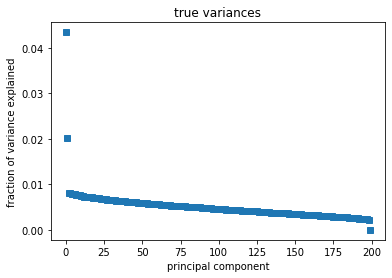

In [6]:
# run svd on the log of the data, project data onto 2 principal components
U, S, W_t = svd(np.log(data))
W_t[0] *= -1
U_q = U[:,:2]
S_q = np.diag(S[:2])
y_q = U_q @ S_q
y_q[:,0] *= -1

# compute eigenvalues from singular values, plot percent variance explained by each component
Lambda = (np.diag(S)**2)/(len(data)-1)
eig_vals = np.diag(Lambda/(np.sum(Lambda)))
plt.plot(eig_vals, 's')
plt.xlabel('principal component')
plt.ylabel('fraction of variance explained')
plt.title('true variances')
plt.show()

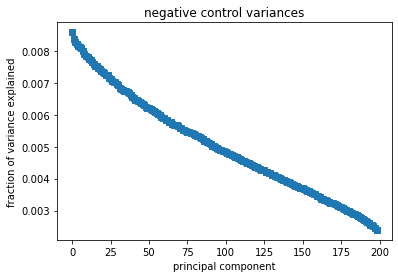

In [7]:
# read in negative contol data
with open("w11-eigen.tbl", "r") as infile:
    infile = infile.readlines()

infile = [line.strip().split() for line in infile]
neg_control = np.array(infile)[:,1]
neg_control = [float(x) for x in neg_control]

# compute fraction of variance for each component and graph to compare to previous
neg_control = neg_control/np.sum(neg_control)
plt.plot(neg_control, 's')
plt.xlabel('principal component')
plt.ylabel('fraction of variance explained')
plt.title('negative control variances')
plt.show()

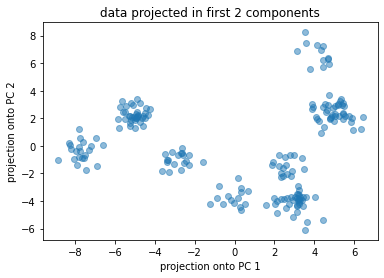

In [8]:
# plot the projected data
plt.scatter(y_q[:,0], y_q[:,1], alpha=.5)
plt.xlabel('projection onto PC 1')
plt.ylabel('projection onto PC 2')
plt.title('data projected in first 2 components')
plt.show()

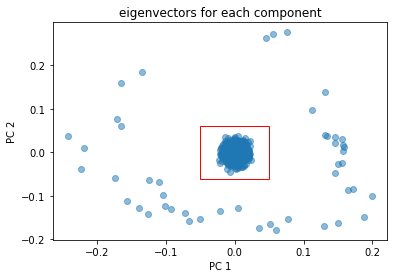

In [9]:
# plot the eigenvector loadings for first two components
fig, ax = plt.subplots(1)
plt.scatter(W_t[0], W_t[1], alpha=.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('eigenvectors for each component')

# add a box around central points to show genes that are not influential
box = patches.Rectangle((-0.05, -0.06), 0.1, 0.12, edgecolor='red', facecolor='none')
ax.add_patch(box)
plt.show()

In [10]:
loadings = W_t.T[:,:2]

# use the graph above to filter and extract the genes that are influential to cell type
count = 0
impt_genes = []
for i in range(len(loadings)):
    if not ((-0.05 < loadings[i,0] < 0.05) and (-0.06 < loadings[i,1] < 0.06)):
        count += 1
        impt_genes.append(i)

print('there are', count, 'genes appearing to influence cell type based on these eigenvector loadings for PCs 1 and 2\n')
print('the genes are:', impt_genes)

there are 47 genes appearing to influence cell type based on these eigenvector loadings for PCs 1 and 2

the genes are: [84, 88, 136, 152, 235, 238, 255, 317, 341, 377, 387, 420, 538, 548, 631, 632, 659, 662, 805, 971, 979, 988, 1022, 1093, 1118, 1134, 1171, 1220, 1232, 1317, 1354, 1409, 1427, 1485, 1492, 1498, 1594, 1602, 1608, 1616, 1704, 1766, 1786, 1787, 1933, 1934, 1952]


Looking at the eigenvalue plots, we can see that the first two principal components explain much more of the variance that any of the other components. Comparing this to the negative control data set, there is a clear distinction between the first two PCs and the rest. When we plot the data projected onto these two components, we can clearly see eight distinct clusters, which supports Watson's expectation.

Using the eigenvector plot, we can see that the large majority of the 2001 genes are clusters around 0,0, indicating that they are not very influential to cell type. Thus, we can filter these out to get just 47 genes that are important to these components. 

# 3. check the K

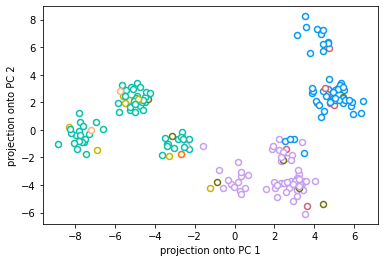

In [11]:
# visualization with our initial k-means run, poor clustering
visualize_data(y_q, best_means, best_clusters, False)
plt.xlabel('projection onto PC 1')
plt.ylabel('projection onto PC 2')
plt.show()

Obviously, this clustering does not match the groupings that are evident in the projected data. I would guess that this is due to the noise present in the data, and that by clustering the data projected onto the first two principal components instead, we can get a much better clustering. 

In [12]:
# run k-means again, this time on the data in 2D PC space
best_pc_dist = float('inf')
for i in range(20):
    kp, centroids, assignments, pc_dist = kmeans(y_q, 8, False)
    if pc_dist < best_pc_dist:
        best_pc_dist = pc_dist
        best_pc_means = centroids
        best_pc_clusters = assignments

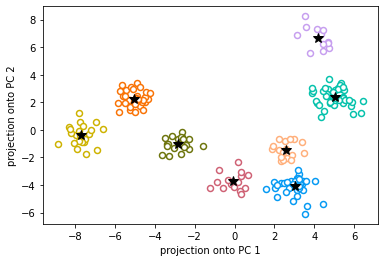

In [13]:
# visualize new clustering, works great!
visualize_data(y_q, best_pc_means, best_pc_clusters, True)
plt.xlabel('projection onto PC 1')
plt.ylabel('projection onto PC 2')
plt.show()

# 4. reconstruct the expression patterns

In [14]:
# reconstruct data using just the first two components
U_q = U[:,0:2]
S_q = np.diag(S[0:2])
Wt_q = W_t[0:2]

X_denoise = U_q @ S_q @ Wt_q

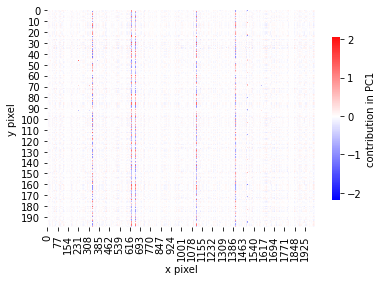

In [15]:
# this is what the heat map looks like before filtering out non-influential genes, very boring
plt.figure()
sns.heatmap(X_denoise, 
            cmap='bwr', center=0,
            cbar_kws={'label': 'contribution in PC1', 'shrink': 0.75})
plt.xlabel('x pixel'); plt.ylabel('y pixel')
plt.show()

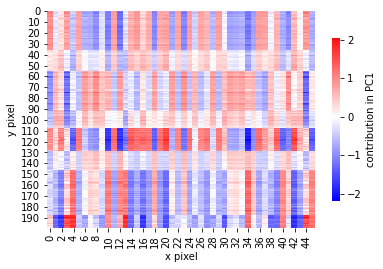

In [16]:
# using the gene indices we pulled earlier, filter our denoised dataset to exclude non-influential genes
X_filtered = []
for gene in impt_genes:
    X_filtered.append(X_denoise.T[gene])

# sort by cluster assignment
X_filtered.append(best_pc_clusters)
X_heat = np.array(X_filtered).T
X_heat = X_heat[np.argsort(X_heat[:, 47])]

# this heat map is a lot more interesting!
plt.figure()
sns.heatmap(X_heat[:,:46], 
            cmap='bwr', center=0,
            cbar_kws={'label': 'contribution in PC1', 'shrink': 0.75})
plt.xlabel('x pixel'); plt.ylabel('y pixel')
plt.show()

After filtering our data and sorting by new cluster assignment, we can see that the 8 clusters are much more evident. Looking at the 200 different y-values, there are 8 distinct horizontal bars or stripes as you move up/down the heat map, which represent the different clusters.